In [36]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


In [37]:



# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [38]:
batch_size = 64
train_dataloader = DataLoader(training_data,batch_size=batch_size)
test_dataloader  = DataLoader(test_data,batch_size=batch_size)

for X , y in test_dataloader:
    print(f"shape of X[N,C,N,W]:{X.shape}")
    print(f"shape of y:{y.shape}{y.dtype}")
    break



shape of X[N,C,N,W]:torch.Size([64, 1, 28, 28])
shape of y:torch.Size([64])torch.int64


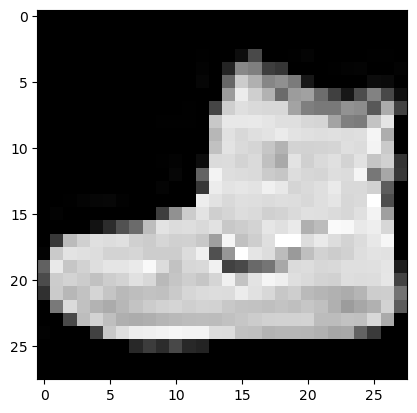

Train batches: 938
Test batches: 157
Batch 0: X shape: torch.Size([64, 1, 28, 28]), y shape: torch.Size([64])


In [26]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import matplotlib.pyplot as plt

# Görselleştirme
plt.imshow(training_data[0][0].squeeze(), cmap="gray")
plt.show()

# DataLoader tanımlamaları
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

# DataLoader kontrolü
print(f"Train batches: {len(train_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")

# İterasyon örneği
for batch_idx, (X, y) in enumerate(train_dataloader):
    print(f"Batch {batch_idx}: X shape: {X.shape}, y shape: {y.shape}")
    if batch_idx == 0:  # Sadece ilk batch'i göster
        break

In [48]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),  # 1. Konvolüsyon katmanı
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),  # 2. Konvolüsyon katmanı
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)  # Overfitting önleme
        )
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (conv_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.25, inplace=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [49]:
model(training_data[5][0])

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x49 and 3136x512)

In [50]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [51]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [52]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [54]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.300019  [   64/60000]
loss: 2.299005  [ 6464/60000]
loss: 2.292537  [12864/60000]
loss: 2.292449  [19264/60000]
loss: 2.287271  [25664/60000]
loss: 2.290538  [32064/60000]
loss: 2.293656  [38464/60000]
loss: 2.289123  [44864/60000]
loss: 2.286681  [51264/60000]
loss: 2.286200  [57664/60000]
Test Error: 
 Accuracy: 24.8%, Avg loss: 2.280495 

Epoch 2
-------------------------------
loss: 2.287858  [   64/60000]
loss: 2.286512  [ 6464/60000]
loss: 2.277720  [12864/60000]
loss: 2.277911  [19264/60000]
loss: 2.273937  [25664/60000]
loss: 2.267963  [32064/60000]
loss: 2.275513  [38464/60000]
loss: 2.266412  [44864/60000]
loss: 2.264311  [51264/60000]
loss: 2.260066  [57664/60000]
Test Error: 
 Accuracy: 30.9%, Avg loss: 2.250627 

Epoch 3
-------------------------------
loss: 2.263276  [   64/60000]
loss: 2.258775  [ 6464/60000]
loss: 2.241778  [12864/60000]
loss: 2.242027  [19264/60000]
loss: 2.233045  [25664/60000]
loss: 2.211341  [32064/600

In [46]:
test(train_dataloader,model,loss_fn)

Test Error: 
 Accuracy: 79.6%, Avg loss: 0.598711 

